In [1]:
library(latex2exp)
library(igraph)
library(ggplot2)
library(pracma)
library(scales)
library(data.table)
library(plyr)
library(readr)
library(stringr)


Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Attaching package: 'readr'


The following object is masked from 'package:scales':

    col_factor




### Question 18

#### Set the path to the gplus files

In [2]:
path = "C:\\Users\\andersons1\\OneDrive - Anglo American\\Desktop\\ECE 232\\ECENGR232E-80\\ECENGR232E-80\\project_2\\gplus\\"

#### Get list of .circles files and remove one empty file

In [3]:
circle_files <- list.files(path=path, pattern="*.circles", full.names=TRUE, recursive=FALSE)
circle_files <- circle_files[!circle_files %in% "C:\\Users\\andersons1\\OneDrive - Anglo American\\Desktop\\ECE 232\\ECENGR232E-80\\ECENGR232E-80\\project_2\\gplus\\111278293763545982455.circles"]

#### Collect each .circle file as a list of lists

In [4]:
circles <- lapply(circle_files, function(x) {
  
  #read the .circle file
  ncol <- max(count.fields(x, sep="\t"))
  d <- read.table(
    x, 
    header = FALSE, 
    sep = "\t", 
    fill = TRUE,
    as.is = TRUE,
    col.names= paste0('V', seq_len(ncol))
    )
  
  #reorganize d as a data.frame
  names <- t(d)[1,]
  d <- t(d[,-1])
  d <- data.frame(d)
  names(d) = names
  
  #append the ego node from the filename into the circle
  ego_node_id <- as.numeric(str_sub(x,-1*nchar("111278293763545982455.circles"),-9))
  egos <- rep(ego_node_id, times=ncol(d))
  d <- rbind(d,egos)
  rownames(d) <- c(1:nrow(d))
  d
  
})

#### Count ego nodes with .circles files that belong to more than n circles

In [5]:
n_circles <- 2
egos_over_two <- length(lengths(circles)[lengths(circles)>n_circles])

#### Count the number of circles

In [6]:
#convert circles into a list of vectors representing one circle each
circles <- unlist(circles,recursive=F)
print(paste("The number of circles is: ",length(circles)))

[1] "The number of circles is:  468"


#### Count the number of circles each node belongs to

In [7]:
#remove NA values from circles
circles <- lapply(circles, function(x){x <- x[!is.na(x)]})

In [8]:
#determine the list of nodes that are contained in at least one circle
circle_nodes <- Reduce(union, circles)

In [9]:
#determine the number of circles that each node belongs to
circle_IDs <- Reduce(c, circles)
circle_freq <- lapply(circle_nodes, function(x){sum(circle_IDs == x)})
nodes_over_two <- length(circle_freq[circle_freq>2])
print(paste("The number of nodes belonging to more than 2 circles is:", nodes_over_two))


[1] "The number of nodes belonging to more than 2 circles is: 6880"


### Question 19

#### Load the desired .edges files

In [10]:
nodes <- c("109327480479767108490","115625564993990145546","101373961279443806744")
edge_files <- c(paste(path,nodes,".edges",sep=""))

#### Load the files and add in the edges for the ego node

In [11]:
#load edge list from file
edges <- lapply(edge_files, function(x){
    d <- read.table(x, header = FALSE, sep = " ", as.is = TRUE)
})
names(edges) <- nodes

#get a list of other nodes in the ego network of each node of interest
ego_nodes <- lapply(edges, function(x){unique(Reduce(c,x))})
names(ego_nodes) <- nodes


#add directed edges between the node of interest and the other nodes
new_edges <- lapply(nodes, function(x){
    n <- length(ego_nodes[[paste(x)]])
    d <- data.frame(
      V1 = c(rep(as.numeric(x),n)),
      V2 = ego_nodes[[paste(x)]]
    )
})
names(new_edges) <- nodes
for(i in 1:length(edges)){
  edges[[i]] <- rbind(edges[[i]],new_edges[[i]])
}


#### Generate personal networks from each edge list

In [12]:
g <- lapply(edges,function(x){
    d <- graph.data.frame(x, directed = TRUE)
})

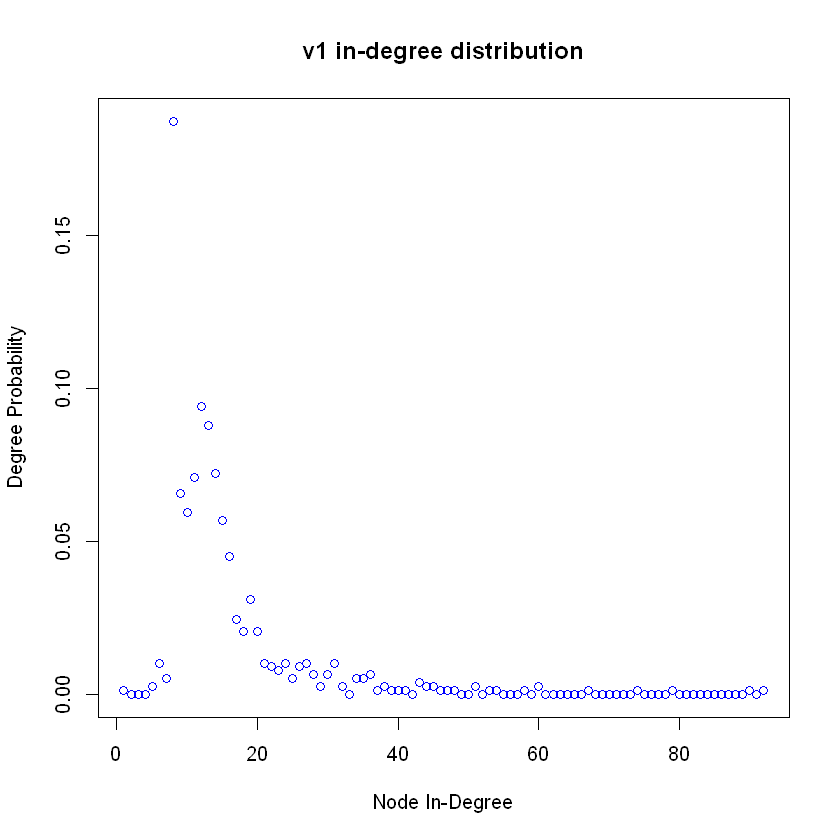

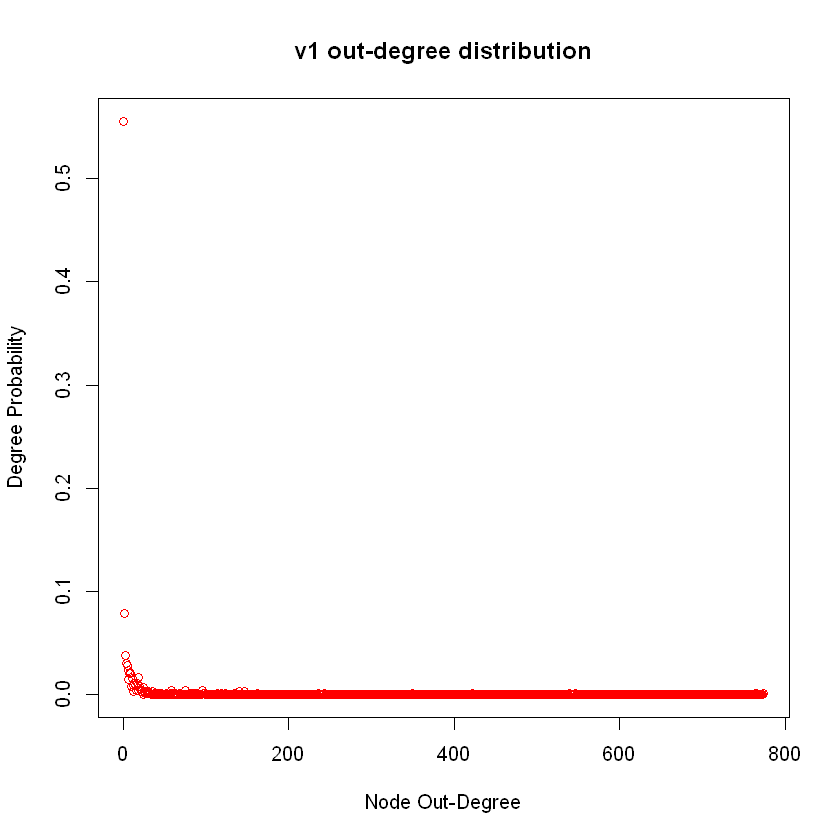

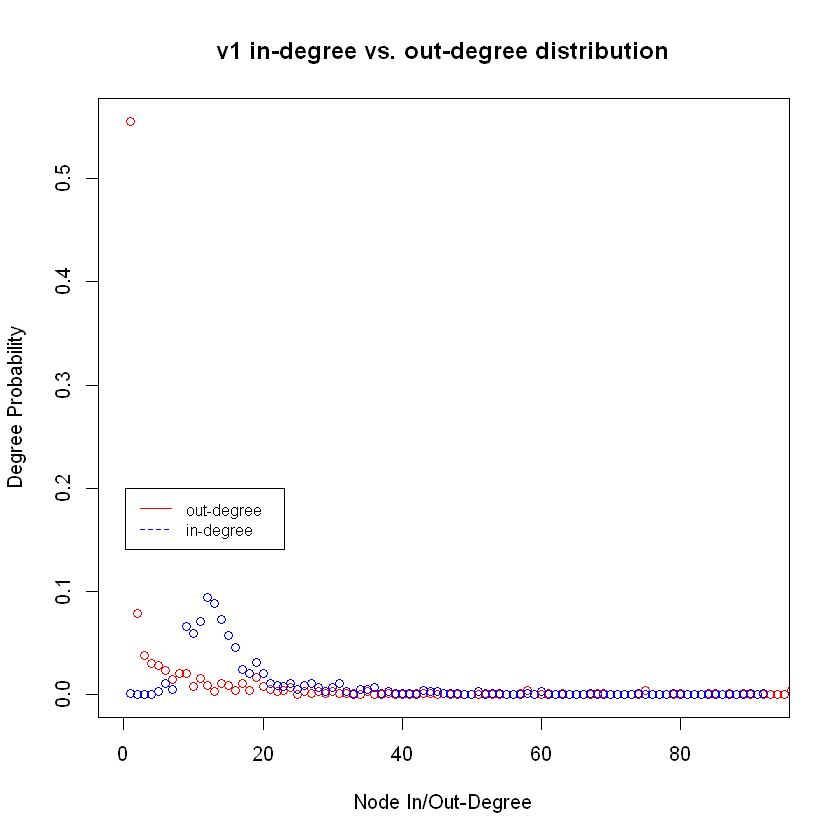

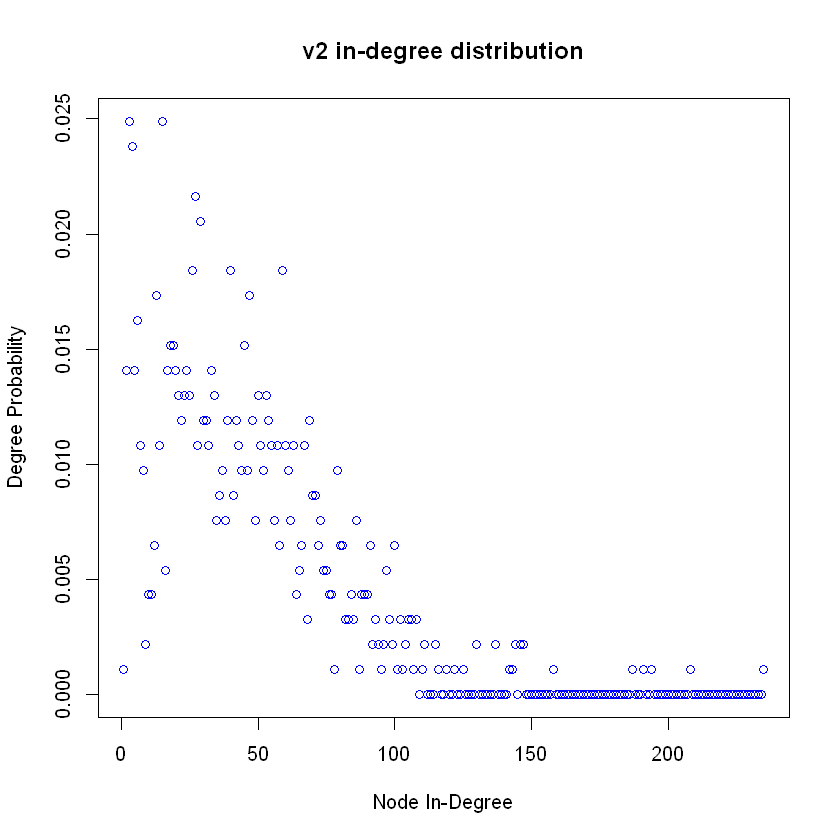

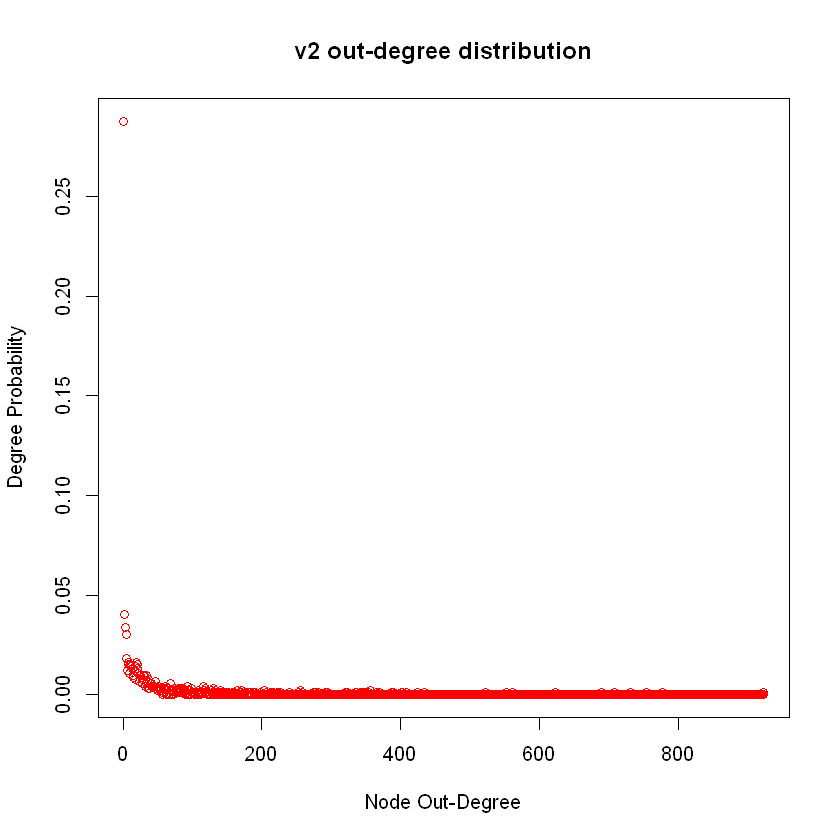

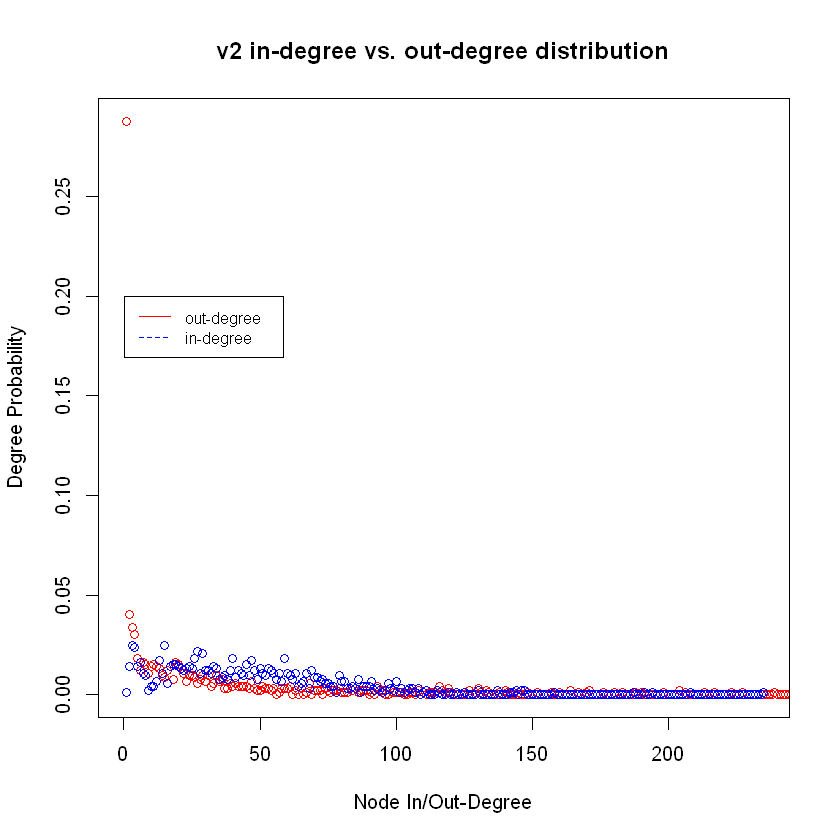

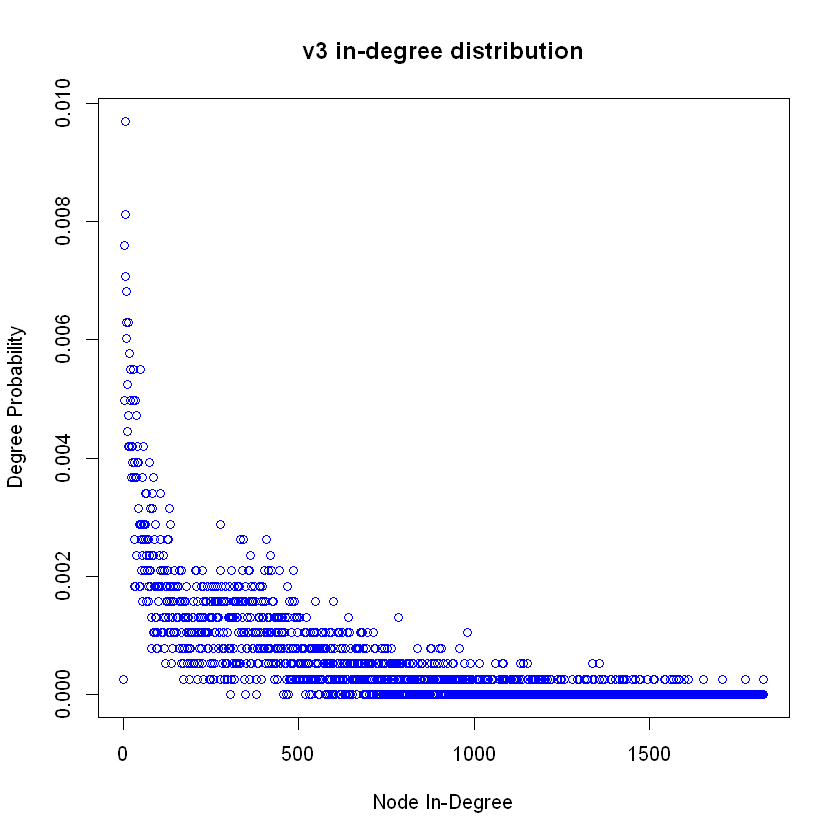

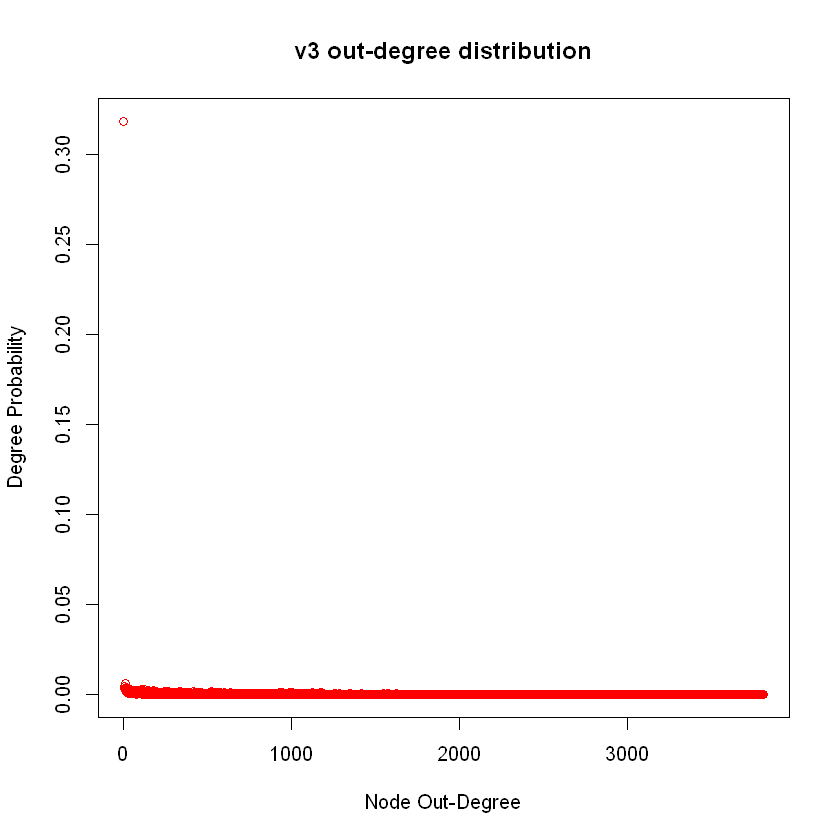

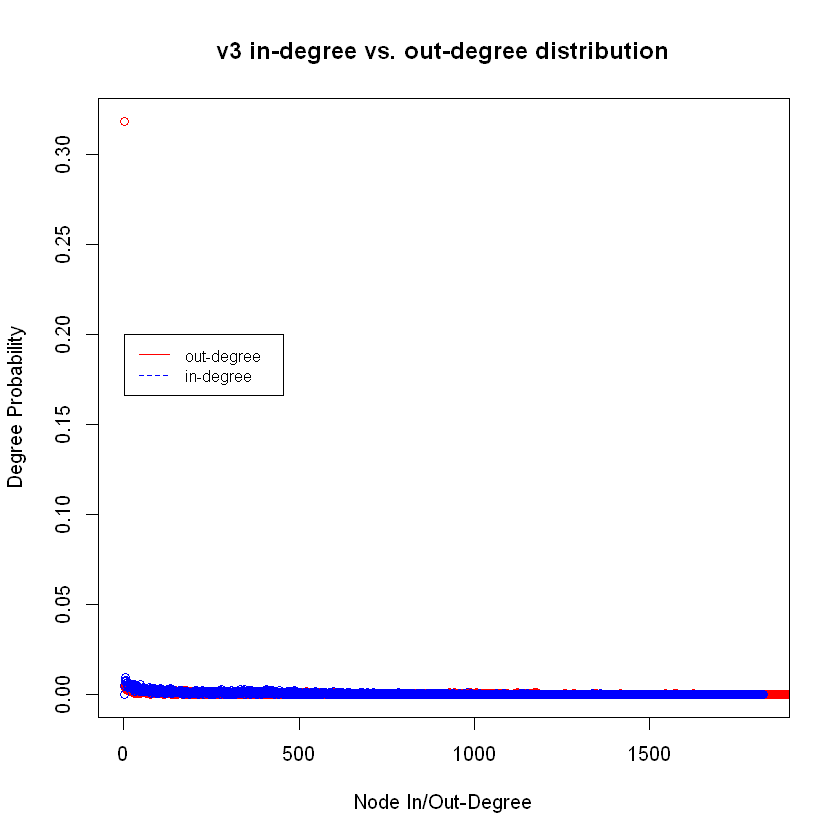

In [13]:
for(i in 1:length(g)){
    plot(degree.distribution(g[[i]],mode="in"),
     col='blue',
     main= paste("v",i," in-degree distribution",sep=""),
     xlab="Node In-Degree",
     ylab="Degree Probability")

    dev.copy(png,paste("images\\question19_v",i,"_in.png",sep=""))
    dev.off()
    
    plot(degree.distribution(g[[i]],mode="out"),
     col='red',
     main= paste("v",i," out-degree distribution",sep=""),
     xlab="Node Out-Degree",
     ylab="Degree Probability")

    dev.copy(png,paste("images\\question19_v",i,"_out.png",sep=""))
    dev.off()
    
    plot(degree.distribution(g[[i]],mode="out"),
     col='red',
     main= paste("v",i," in-degree vs. out-degree distribution",sep=""),
     xlab="Node In/Out-Degree",
     ylab="Degree Probability",
     xlim=c(0,length(degree.distribution(g[[i]],mode="in"))))
    points(degree.distribution(g[[i]],mode="in"),
     col='blue')
    legend(0.2,0.2,legend=c("out-degree","in-degree"),col=c("red","blue"),bty="o",lty=1:2, cex=0.8)

    dev.copy(png,paste("images\\question19_v",i,"_vs.png",sep=""))
    dev.off()

}


### Question 20

$`109327480479767108490`
[1] 0.2527654

$`115625564993990145546`
[1] 0.3194726

$`101373961279443806744`
[1] 0.1910903



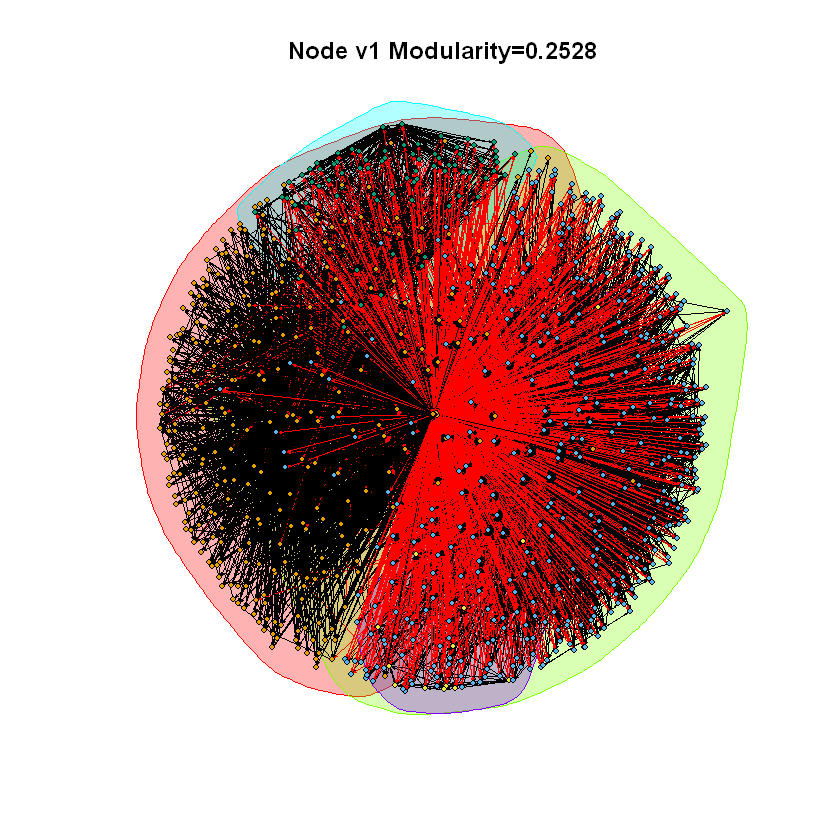

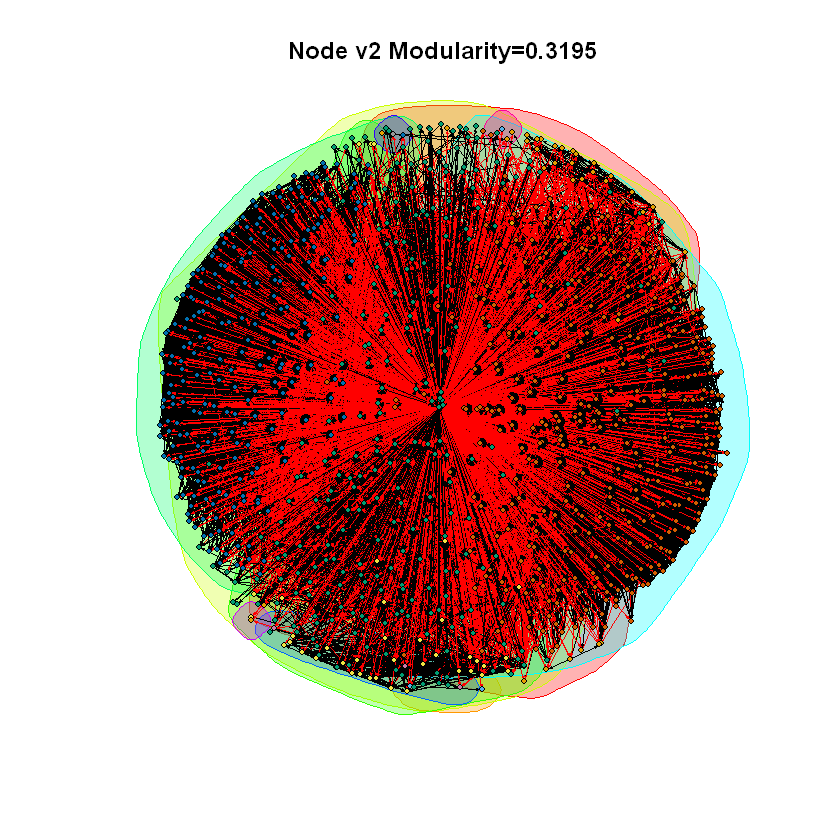

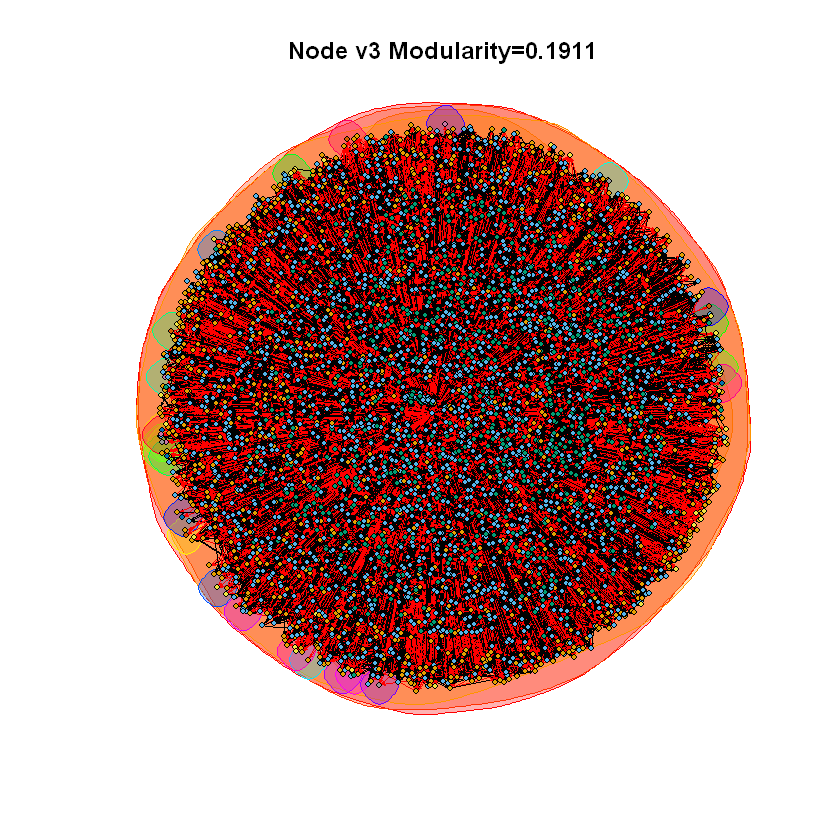

In [14]:
#compute communities
clusters <- lapply(g,function(x){cluster_walktrap(x)})

#compute modularities
modularities <- lapply(clusters,function(x){modularity(x)})
print(modularities)

#plot community structure
for(i in 1:length(g)){
  filename <- paste("images\\question20_v",i,".png",sep="")  
  plot(
      clusters[[i]],
      g[[i]],
      layout=layout_with_kk(g[[i]], dim=2),
      target=filename,
      vertex.label=NA,
      vertex.size=2,
      edge.width = 0.1,
      edge.arrow.size = 0.1,
      margin=c(0,0,0,0),
      main=sprintf("Node v%d Modularity=%.4f",i,modularities[i])
      )
  dev.copy(png,filename,width = 800, height = 800)
  dev.off()
}


### Question 22

In [17]:
#identify the nodes with circle information in each personal network
nodeIDs <- lapply(edges,function(x){
  d <- unique(c(x[,1],x[,2]))
})

nodesIDs_cinfo <- lapply(nodeIDs,function(x){
  d <- x[x %in% circle_nodes]
})

N <- lapply(nodesIDs_cinfo,function(x){
  d <- length(x)
})

#identify the intersection of the circles and the personal networks
personal_circles <- lapply(nodesIDs_cinfo,function(x){
  d <- lapply(circles,function(y){
    j <- y[y %in% x]
  })
})

#measure the number of nodes in each circle
a <- lapply(personal_circles,function(x){
  d <- lapply(x,function(y){
    j <- length(y)
  })
})

#convert personal_circles data type to character to match symbolic node IDs
personal_circles <- lapply(personal_circles,function(x){
  d <- lapply(x,function(y){
    j <- lapply(y,function(z){
       e <- as.character(z)  
    })
  })
})

#convert the nodesIDs_cinfo data type to character to match symbolic node IDs
nodesIDs_cinfo <- lapply(nodesIDs_cinfo,function(x){
  d <- lapply(x,function(y){e<-as.character(y)})
})

#determine the communities in each personal network
k <- lapply(clusters,function(x){
  d <- membership(x)
})

num_k <- lapply(k,function(x){
  d <- max(x)
})

#assign nodes without circle information to community zero
for(i in 1:length(k)){
  for(j in 1:length(k[[i]])){
    if(!names(k[[i]][j]) %in% unlist(nodesIDs_cinfo[[i]])){k[[i]][j]<-0}
  }
}

#collect list of circle-info nodes in each community
personal_communities <- lapply(1:length(k),function(x){
  n <- 1:num_k[[x]]
  d <-lapply(n,function(y){
    e <- names(k[[x]][k[[x]]==y])
  })
  names(d) <- c(n)
  d
})

names(personal_communities) <- nodes

#count the number of circle-info nodes in each community
b <- lapply(personal_communities,function(x){
  d <- lapply(x,function(y){
    e <- length(y)
  })
})

#determine the size of the intersection between each circle and community
dimA = matrix(0,ncol=length(nodes),nrow=2)
for(i in 1:length(nodes)){
  dimA[1,i]<-length(personal_circles[[i]])
  dimA[2,i]<-length(personal_communities[[i]])
}

A <- num_k

for(i in 1:length(nodes)){
  A[[i]]<-matrix(0,ncol=dimA[1,i],nrow=dimA[2,i])
}

for(l in 1:length(nodes)){
  for(j in 1:nrow(A[[l]])){
    for(i in 1:ncol(A[[l]])){
      p1 <- unlist(personal_circles[[names(A[l])]][[i]])
      p2 <- personal_communities[[names(A[l])]][[j]]
      A[[l]][j,i] <- sum(p1 %in% p2)
    }
  }
}


#calculate circle entropy

h_c <- num_k
for(i in 1:length(nodes)){
  d <- 0
  for(j in 1:length(a[[i]])){
    a_i <- a[[i]][[j]]
    s_i <- a_i/N[[i]]
    h_i <- -1*s_i*log(s_i,2)
    if(is.nan(h_i)){h_i<-0}
    d <- d + h_i
  }
  h_c[[i]] <- d
}

#calculate community entropy

h_k <- num_k
for(i in 1:length(nodes)){
  d <- 0
  for(j in 1:length(b[[i]])){
    b_i <- b[[i]][[j]]
    s_i <- b_i/N[[i]]
    h_i <- -1*s_i*log(s_i,2)
    if(is.nan(h_i)){h_i<-0}
    d <- d + h_i
  }
  h_k[[i]] <- d
}

#calculate conditional circle|community entropy

h_ck <- num_k
for(l in 1:length(nodes)){
  d <- 0
  
  for(j in 1:nrow(A[[l]])){
    
    b_j <- b[[l]][[j]]
    
    for(i in 1:ncol(A[[l]])){
      A_ji <- A[[l]][j,i]
      h <- -1*A_ji/N[[l]]*log(A_ji/b_j,2)
      if(is.nan(h)){h<-0}
      d <- d + h
    }
  }
  
  h_ck[[l]] <- d
}

#calculate conditional community|circle entropy

h_kc <- num_k
for(l in 1:length(nodes)){
  d <- 0
  
  for(j in 1:nrow(A[[l]])){
    
    
    
    for(i in 1:ncol(A[[l]])){
      A_ji <- A[[l]][j,i]
      a_i <- a[[l]][[i]]
      h <- -1*A_ji/N[[l]]*log(A_ji/a_i,2)
      if(is.nan(h)){h<-0}
      d <- d + h
    }
  }
  
  h_kc[[l]] <- d
}


#calculate homogeneity and completeness

homogeneity <- num_k
completeness <- num_k

for(l in 1:length(nodes)){
 
  homogeneity[[l]]<-1-h_ck[[l]]/h_c[[l]]
  completeness[[l]]<-1-h_kc[[l]]/h_k[[l]]
  
}


$`109327480479767108490`
[1] 0.4557404

$`115625564993990145546`
[1] 0.3178207

$`101373961279443806744`
[1] 0.03391807

$`109327480479767108490`
[1] 0.009149606

$`115625564993990145546`
[1] -3.640525

$`101373961279443806744`
[1] -2.1237

